# **응급상황 자동 인식 및 응급실 연계 서비스**
# 단계2 : 파인튜닝!

## **0.미션**

### (1) 미션1
단계 2에서는 사전 학습된 한국어 BERT 모델을 다운받아, 파인튜닝을 시도합니다. 이를 위해 먼저 적절한 데이터를 수집해야 합니다.

* 학습 데이터 준비
    * 등급별 50개씩 샘플 데이터를 제공합니다.
    * **응급상황 등급(1~5) 별 최소 100건씩** 데이터를 추가로 수집(제작)하세요.
        * 중증도 카테고리 파일에 있는 키워드 참조
        * 제작시 GPT를 적극 활용해 봅시다.
    * 총 데이터 크기 : 600건
        * 제공데이터 100건(20건씩 5개 등급)
        * 추가 제작 500건(100건씩 5개 등급)

|text|label|
|----|----|
|GPT모델의 출력 형태. 응급상황 내용 | 응급등급(1~5)|



### (2) 미션2
미션1에서 준비한 학습데이터를 활용해서 파인튜닝을 시도합니다.

* 사용할 모델 : **klue/bert-base**
* 성능을 높이기 위해 조정할 만한 점(아래 수치는 가이드)
    - 데이터 양 늘리기
    - 하이퍼 파라미터
        - epoch 수 : 5 ~ 20
        - learning_rate : 1e-5 ~ 1e-2
        - batch_size : 16 ~ 32
        - weight_decay : 0.01 ~ 0.1

## 1.환경준비

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project6 폴더를 만들고,
        * 제공 받은 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 라이브러리 설치 및 로딩

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


* (필요 시) 설치 후 세션 다시 시작

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from warnings import filterwarnings
FutureWarning
filterwarnings('ignore')

* 함수 생성
    * evaluate : 모델 생성후, 데이터셋(예 : 검증셋)을 이용해서 모델 성능을 평가하기 위한 용도
    * predict :  하나의 문장을 입력받아, 예측결과를 반환

In [3]:
# 검증셋 평가 함수
def evaluate(val_ds, model, device, tokenizer):
    # 입력 데이터셋 토크나이징 (attention_mask 포함)
    inputs = tokenizer(val_ds['text'], return_tensors="pt", padding=True,
                       truncation=True, max_length=128
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 입력 텐서를 동일한 디바이스로 이동

    # 모델을 지정된 디바이스로 이동
    model = model.to(device)

    with torch.no_grad():  # 평가 과정에서 기울기 계산 비활성화
        outputs = model(**inputs)  # attention_mask를 포함해 입력

    # 예측 및 확률 계산
    probabilities = outputs.logits.softmax(dim=1)

    # probabilities가 GPU에 있을 경우에만 CPU로 이동
    if probabilities.is_cuda:
        probabilities = probabilities.cpu().detach().numpy()
    else:
        probabilities = probabilities.detach().numpy()

    pred = np.argmax(probabilities, axis=1)

    # GPU 메모리에서 필요 없는 텐서 제거 및 캐시 정리
    del inputs
    torch.cuda.empty_cache()

    return pred, probabilities

In [4]:
# 데이터 예측 함수
def predict(text, model, tokenizer):
    # 입력 문장 토크나이징
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 각 텐서를 GPU로 이동

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)

    # 로짓을 소프트맥스로 변환하여 확률 계산
    logits = outputs.logits
    probabilities = logits.softmax(dim=1)

    # 가장 높은 확률을 가진 클래스 선택
    pred = torch.argmax(probabilities, dim=-1).item()

    return pred, probabilities

### (2) 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project6_2/'

### (3) 데이터 로딩
* 이전 미션에서 준비한 데이터셋을 로딩합니다.

In [ ]:
data = pd.read_csv(path + 'dataset.csv', encoding='euc-kr')
data.tail()

,text,label
561,급성 중심성 경증 통증(<4)을 느끼며 약간의 불편함을 호소하는 상태,5
562,하지의 경미한 외상으로 인해 걸을 때 약간의 통증을 느끼는 환자,5
563,만성 중심성 경증 통증(<4)으로 인해 가벼운 통증을 겪으며 약물을 필요로 하지 않...,5
564,눈 충혈과 가벼운 분비물로 인해 약간의 불편함을 느끼는 환자,5
565,코막힘으로 인해 숨쉬기가 약간 불편하지만 안정적인 상태를 유지하는 환자,5


* y 분포 확인하기

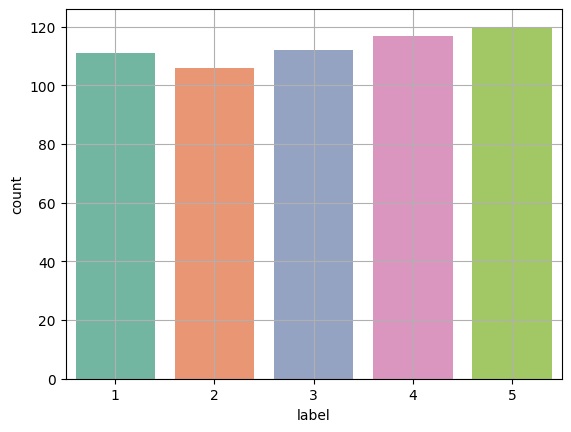

In [ ]:
sns.countplot(x='label', data = data, palette='Set2')
plt.grid()
plt.show()

* label 에 대한 정수 인코딩
    * 정수 인코딩은 0 부터 시작해야 함.

In [ ]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
data['label'] = LE.fit_transform(data['label'])
data.head()

,text,label
0,환자가 심각한 호흡곤란으로 숨을 쉬기 어려워하며 피부가 푸르스름하게 변색된 상태,0
1,환자가 얼굴이 창백하고 식은땀을 흘리며 맥박이 거의 잡히지 않는 쇼크 상태,0
2,"환자가 바닥에 쓰러져 의식을 잃었고, 주변의 소리에 반응하지 않으며, 몸이 움직이지...",0
3,환자가 심한 호흡곤란으로 숨을 쉬지 못해 곤란해하는 상태,0
4,환자가 심각한 쇼크로 인해 혈압이 떨어지고 의식을 잃을 위험에 있는 상태,0


In [ ]:
data.tail()

,text,label
561,급성 중심성 경증 통증(<4)을 느끼며 약간의 불편함을 호소하는 상태,4
562,하지의 경미한 외상으로 인해 걸을 때 약간의 통증을 느끼는 환자,4
563,만성 중심성 경증 통증(<4)으로 인해 가벼운 통증을 겪으며 약물을 필요로 하지 않...,4
564,눈 충혈과 가벼운 분비물로 인해 약간의 불편함을 느끼는 환자,4
565,코막힘으로 인해 숨쉬기가 약간 불편하지만 안정적인 상태를 유지하는 환자,4


### (4) GPU 설정
* 파이토치를 위한 설정

In [ ]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.데이터 준비

### (1) Dataset 만들기 : train, val

In [ ]:
# 데이터셋 분할
train, val = train_test_split(data, test_size=.2, random_state=42)

In [ ]:
# 텐서 데이터셋으로 변환
train_ds = Dataset.from_pandas(train)
val_ds = Dataset.from_pandas(val)

In [ ]:
train_ds[:5]

{'text': ['도주할 가능성이 있는 환자가 자신이나 타인의 안전을 위협하는 상황',
  '환자가 의식이 혼미해지며 눈동자가 천천히 움직이는 상태',
  '환자가 심각한 호흡곤란으로 숨을 쉬기 어려워하며 피부가 푸르스름하게 변색된 상태',
  '경증 호흡곤란을 느끼는 환자가 숨을 가쁘게 쉬며 안정을 찾으려 하고 있습니다.',
  '건강한 상태에서 조절되지 않는 위험한 행동을 보이는 환자'],
 'label': [1, 1, 0, 2, 0],
 '__index_level_0__': [117, 211, 0, 328, 11]}

### (2) 토큰화

* 사용할 모델("klue/bert-base")의 토크나이저를 저장

In [ ]:
# 모델과 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

In [ ]:
# 토큰화 함수 생성 및 적용
def preprocess_function(data):
    return tokenizer(data['text'], truncation=True, padding=True)

train_ds = train_ds.map(preprocess_function, batched=True)
val_ds = val_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/452 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

## 3.Fine-Tuning

### (1) 사전학습 모델 준비
* 사용할 모델("klue/bert-base")의 토크나이저를 저장
* 이때, 출력층 노드 수를 지정합니다.

In [ ]:
# 모델 설정 (다중 분류를 위해 num_labels 지정)
n = len(data['label'].unique())
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels = n).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### (2) 학습
* 절차
    * TrainArguments 설정
        * 조정할 하이퍼파라미터 : learning_rate, batch_size, epochs, weight_decay 등
        * 나머지 옵션은 손 대지 맙시다.
    * Trainer 설정
    * 학습
* 성능 : 데이터, 하이퍼파라미터에 의해 결정

In [ ]:
# TrainingArguments

lr = 5e-5                # <--1e-5, 3e-5, 2e-5, 5e-5
batch_size = 32        # <--16, 32
epochs = 3            # <--

training_args = TrainingArguments(
    output_dir = './results',          # 출력 디렉토리
    eval_strategy = "epoch",            # 에폭마다 평가
    save_strategy = "epoch",           # 에폭마다 체크포인트 저장
    learning_rate = lr,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs  = epochs,
    weight_decay = 0.02,               # <--[조정가능]weight decay
    load_best_model_at_end = True,     # 가장 좋은 모델을 마지막에 로드
    logging_dir ='./logs',            # 로깅 디렉토리
    logging_steps = 10,                # 로깅 스텝
    report_to="tensorboard"          # TensorBoard에 로깅
)

In [ ]:
# Trainer 설정
patience = 2       # <--

trainer = Trainer(
    model=model,                         # 학습할 모델
    args=training_args,                  # TrainingArguments
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)], # 조기 종료
)

In [ ]:
# 모델 학습
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.000500,0.550624
2,0.000300,0.595042
3,0.000200,0.555266


TrainOutput(global_step=87, training_loss=0.00037939356233196697, metrics={'train_runtime': 46.851, 'train_samples_per_second': 48.238, 'train_steps_per_second': 3.095, 'total_flos': 22299262573824.0, 'train_loss': 0.00037939356233196697, 'epoch': 3.0})

In [ ]:
# 모델 평가
eval_result = trainer.evaluate()
print(eval_result)

{'eval_loss': 0.5506243109703064, 'eval_runtime': 0.2659, 'eval_samples_per_second': 428.674, 'eval_steps_per_second': 30.082, 'epoch': 3.0}


### (3) 모델 검증평가
* evaluate 함수를 이용해서 검증셋에 대한 성능 평가를 수행합니다.

In [ ]:
pred, prob = evaluate(val_ds, model, device, tokenizer)

In [ ]:
print(confusion_matrix(val_ds['label'], pred))
print(classification_report(val_ds['label'], pred, target_names = ['1','2','3','4','5']))

[[26  3  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 24  0  0]
 [ 0  1  1 16  0]
 [ 0  0  0  4 19]]
              precision    recall  f1-score   support

           1       1.00      0.90      0.95        29
           2       0.83      1.00      0.91        20
           3       0.96      1.00      0.98        24
           4       0.80      0.89      0.84        18
           5       1.00      0.83      0.90        23

    accuracy                           0.92       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.92      0.92       114



In [ ]:
scoresByParams = pd.DataFrame(columns=['learning_rate', 'batch_size', 'epochs', 'val_loss', 'accuracy_score'])
scoresByParams.head()

,learning_rate,batch_size,epochs,val_loss,accuracy_score


In [ ]:
# 모델의 하이퍼 파라미터 & 성능 저장
scoresByParams.loc[len(scoresByParams)] = [lr, batch_size, epochs, eval_result['eval_loss'], accuracy_score(val_ds['label'], pred)]
scoresByParams.head()

,learning_rate,batch_size,epochs,val_loss,accuracy_score
0,0.00005,32.0,3.0,0.293374,0.912281
1,0.00005,16.0,3.0,0.387952,0.894737
2,0.00001,16.0,5.0,0.392834,0.903509
3,0.00002,32.0,4.0,0.406289,0.903509
4,0.00003,32.0,3.0,0.396624,0.912281


In [ ]:
scoresByParams.to_csv(path + 'scoresByParams.csv', index=False)

### (4) 모델 사용
* 응급상황에 대한 샘플 문자을 넣고 등급을 적절히 분류하는지 눈으로 확인해 봅시다.

In [ ]:
text = "차에 치여서 숨을 안쉬는 상태입니다"
text3 = "열이 나고 두통이 있으며 몸살기운이 있어요"
text5 = "코가 막혀서 숨 쉬는게 불편한 상태"
predicted_class, probabilities = predict(text5, model, tokenizer)

print(f"예측된 클래스: {predicted_class}")
print(f"예측된 클래스 이름: {LE.inverse_transform([predicted_class])}")
print(f"클래스별 확률: {probabilities}")

예측된 클래스: 4
예측된 클래스 이름: [5]
클래스별 확률: tensor([[1.3381e-04, 7.7768e-05, 4.1653e-05, 4.0941e-05, 9.9971e-01]],
       device='cuda:0')


## 4.모델 저장

### (1) 모델 저장
* save_pretrained 메서드를 사용해 모델과 토크나이저를 디렉토리에 저장합니다.
* 저장 대상 : 모델, 토크나이저

In [ ]:
# 모델과 토크나이저 저장 경로 : 폴더가 없으면, fine_tuned_bert를 생성
save_directory = path + "fine_tuned_bert"

# 모델 저장
model.save_pretrained(save_directory)

# 토크나이저도 함께 저장
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/KT미프/6_2차/fine_tuned_bert/tokenizer_config.json',
 '/content/drive/MyDrive/KT미프/6_2차/fine_tuned_bert/special_tokens_map.json',
 '/content/drive/MyDrive/KT미프/6_2차/fine_tuned_bert/vocab.txt',
 '/content/drive/MyDrive/KT미프/6_2차/fine_tuned_bert/added_tokens.json',
 '/content/drive/MyDrive/KT미프/6_2차/fine_tuned_bert/tokenizer.json')

### (2) 모델 로딩 및 사용
* 저장한 모델을 나중에 다시 불러와 예측이나 추가 작업에 사용할 수 있습니다. Hugging Face from_pretrained 메서드를 사용하여 저장 경로에서 모델과 토크나이저를 로드합니다.
* 로딩 대상 : 모델, 토크나이저

In [ ]:
save_directory = path + "fine_tuned_bert"

# 모델 로드
loaded_model = AutoModelForSequenceClassification.from_pretrained(save_directory).to(device)

# 토크나이저 로드
loaded_tokenizer = AutoTokenizer.from_pretrained(save_directory)

In [ ]:
text = "넘어졌는데, 지금 출혈이 있고, 머리가 어지럽습니다."
predicted_class, probabilities = predict(text, loaded_model, loaded_tokenizer)

print(f"예측된 클래스: {predicted_class}")
print(f"예측된 클래스 이름: {predicted_class+1}등급")
print(f"클래스별 확률: {probabilities}")

예측된 클래스: 2
예측된 클래스 이름: 3등급
클래스별 확률: tensor([[0.1806, 0.1020, 0.5290, 0.1181, 0.0704]], device='cuda:0')


## **Mission Complete!**

수고 많았습니다!